In [179]:
import pandas as pd
import numpy as np
import seaborn as sns

import yfinance as yf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [180]:
ticker_symbol = 'AAPL'
data = yf.Ticker(ticker_symbol)

In [181]:
prices = data.history(start='2021-01-01', end='2021-04-10').Close

Text(0, 0.5, 'Share Price')

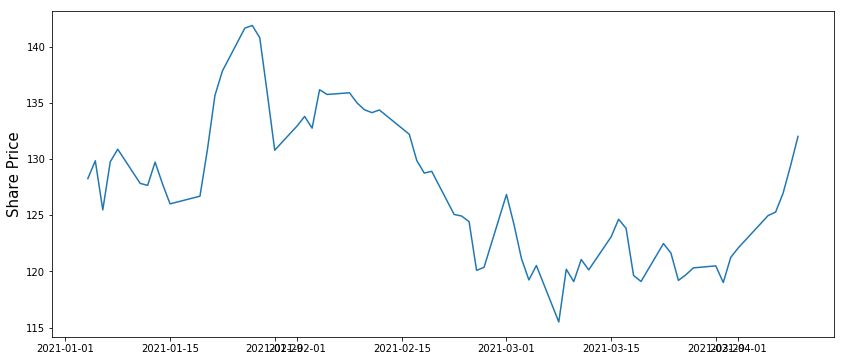

In [182]:
plt.figure(figsize=(14,6))
plt.plot(prices)
plt.ylabel('Share Price', fontsize=15)

## Clearly Prices are not stationary, cannnot fit time series model directly to price data

Text(0, 0.5, 'Daily Return on Apple Share')

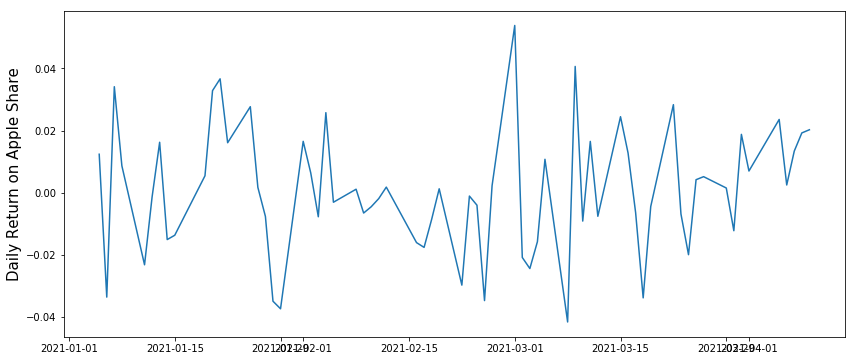

In [183]:
returns = prices.pct_change().dropna()
plt.figure(figsize=(14, 6))
plt.plot(returns)
plt.ylabel("Daily Return on Apple Share", fontsize=15)

### Looks like Stationary, 3 type of Stationary:- 

     1. Trend Stationary
     2. Seasonal Stationary
     3. Strictly Stationary : Joint Distribution of observations

### Augmented Dickey-fuller test (Unit root test)

### Null: Time series data is not stationary
### Alternate: it is stationary

In [184]:
# testing for stationary conditions

from statsmodels.tsa.stattools import adfuller
values = returns.values

res = adfuller(values)

if res[1] > 0.05:
    print("Apple returns are not stationary")
else:
    print("Reject the Null, apple returns are stationary")

Reject the Null, apple returns are stationary


## Fitting the ARMA model in the return series that is already Stationary

### ACF plot will give us number of lags that are to be included as a MA part while PACF plot will give us number of lags that are to be included as a AR part 

In [185]:
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

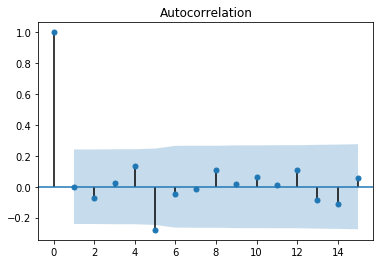

In [186]:
plot_acf(returns, lags=15)
plt.show()

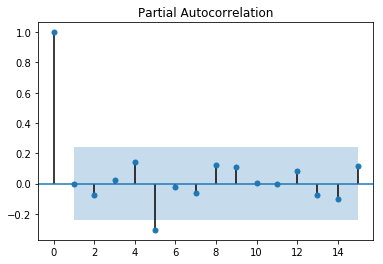

In [187]:
plot_pacf(returns, lags=15)
plt.show()

### Only lag = 5 show a little bit of statistical significance. 

### For the purpose of learning, we will choose lag = 5 for both AR and MA part of fitting ARMA model

## Now we will work on defining a method which will choose to buy or not on any particular day and sell it next day and then try to find whether we can create a strategy around this to generate returns

In [188]:
# for progress bar
from tqdm import tqdm

In [255]:
# plotting the curve where we have bought and sell next day to look whether we have made profit or loss

def plotting_strategy(prices, events_list, final_amt, init_amt):
    plt.figure(figsize=(18,6))
    plt.plot(prices)
    
    y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
    shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)
    
    for idx, event in enumerate(events_list):
        plt.axvline(event[1], color='k', linestyle='--', alpha=0.5)
#         if event[0] == 's':
#             color = 'green' if event[2] > 0 else 'red'
#             plt.fill_between(range(*shaded_y_lims), event[1], events_list[idx-1][1], color=color, alpha=0.1)
    
    tot_return = round(100*(final_amt/init_amt -1 ), 2)
    tot_return = str(tot_return) + '%'

    return

In [272]:
def run_simulation(prices, returns, amt_invested, order_of_arima, threshold, type_of_strategy):
    
    if type_of_strategy == 'random':
        threshold = None
        
    curr_holding = False
    events_list = []
    init_amt = amt_invested
    buy_price = prices.loc[returns.index[0]]
    
    for date, r in tqdm(returns.iloc[:].items(), total=len(returns.iloc[:])):
        # get data till this data as only this info is available to make decision
        curr_data = returns[:date]
        
        # if i have bought last day, then i need to sell it today
        if curr_holding:
            sell_price = prices.loc[date]
#             print(f"Sell Price is {sell_price}" )
            curr_holding = False
            ret = (sell_price - buy_price) / buy_price
            amt_invested *= (1 + ret)
            events_list.append(('s', date, ret))
            
        if type_of_strategy == 'arima':
            try:
                model = ARIMA(curr_data, order=order_of_arima).fit(maxiter=200)
                pred = model.forecast()[0][0] # next day of forecast
            except:
                pred = threshold - 1
        
        # if you pred high positive return and not holding stock, then buy it
        condition_for_random_or_arima = ( (type_of_strategy == 'random' and np.random.random() < order_of_arima) or (type_of_strategy == 'arima' and pred > threshold))
        if (not curr_holding) and condition_for_random_or_arima:
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
#             print(f"Buy Price is {buy_price}" )
            
    print(f"Total amount of {init_amt} end up as {amt_invested}")
    
#     plotting_strategy(prices, events_list, amt_invested, init_amt)
    
    return amt_invested

In [275]:
random_sample_result = [ run_simulation(prices, returns, 100, 0.5, 0.001, 'random') for _ in range(1000)]

  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 95.78451009141243
Total amount of 100 end up as 101.13586025204205
Total amount of 100 end up as 94.84223199691156
Total amount of 100 end up as 103.57952738055256
Total amount of 100 end up as 87.47421710699399
Total amount of 100 end up as 84.94125735853461
Total amount of 100 end up as 114.76066849411346


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 95.42185869400608
Total amount of 100 end up as 94.01629437284271
Total amount of 100 end up as 113.1319421868669
Total amount of 100 end up as 104.75659454536653
Total amount of 100 end up as 104.33649994697585
Total amount of 100 end up as 102.5895751090327
Total amount of 100 end up as 105.67112490955319


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 110.35539143275406
Total amount of 100 end up as 108.25749854185572
Total amount of 100 end up as 93.31810635635428
Total amount of 100 end up as 92.74932241407083
Total amount of 100 end up as 93.06346170792908
Total amount of 100 end up as 103.61070089197084
Total amount of 100 end up as 95.71481445577439


100%|██████████| 66/66 [00:00<00:00, 2934.26it/s]

Total amount of 100 end up as 92.7466944893263
Total amount of 100 end up as 91.76178012459273
Total amount of 100 end up as 100.69188286235759
Total amount of 100 end up as 94.6443813388947
Total amount of 100 end up as 97.46985229273497
Total amount of 100 end up as 119.34956081839125
Total amount of 100 end up as 97.45144650069729



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 103.69612701387332
Total amount of 100 end up as 105.18338288578649
Total amount of 100 end up as 106.01520189203089
Total amount of 100 end up as 97.05326330573715
Total amount of 100 end up as 95.7587138331104
Total amount of 100 end up as 93.90435142851742
Total amount of 100 end up as 92.465683062855


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 94.58253619338616
Total amount of 100 end up as 96.21097504878514
Total amount of 100 end up as 98.1842834198904
Total amount of 100 end up as 99.16666018886053
Total amount of 100 end up as 103.87826706745182
Total amount of 100 end up as 99.0642056621614
Total amount of 100 end up as 105.27641299496791


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 104.18270610719237
Total amount of 100 end up as 106.39451730096381
Total amount of 100 end up as 102.94454838170515
Total amount of 100 end up as 100.64941056232395
Total amount of 100 end up as 97.98913581290768
Total amount of 100 end up as 105.756702461189
Total amount of 100 end up as 101.7181222903416


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 96.63606576312323
Total amount of 100 end up as 97.8561725337469
Total amount of 100 end up as 98.16586207491694
Total amount of 100 end up as 99.8099102009671
Total amount of 100 end up as 94.53132270866307
Total amount of 100 end up as 98.79379416926598
Total amount of 100 end up as 98.54172819552791
Total amount of 100 end up as 104.28150014802169


100%|██████████| 66/66 [00:00<00:00, 3331.86it/s]

Total amount of 100 end up as 112.87640514520851
Total amount of 100 end up as 102.23557253739702
Total amount of 100 end up as 86.69297042389665
Total amount of 100 end up as 102.8457907291172
Total amount of 100 end up as 113.40232920348933
Total amount of 100 end up as 83.96648823095101
Total amount of 100 end up as 104.36836379956083
Total amount of 100 end up as 103.97805001763776



100%|██████████| 66/66 [00:00<00:00, 3456.97it/s]

Total amount of 100 end up as 99.0795549305128
Total amount of 100 end up as 97.35033564617902
Total amount of 100 end up as 102.57265574917423
Total amount of 100 end up as 109.53344393389945
Total amount of 100 end up as 121.5989572333925
Total amount of 100 end up as 102.56956388184247
Total amount of 100 end up as 105.44936855191993
Total amount of 100 end up as 96.10716790466066
Total amount of 100 end up as 118.30830799626129



100%|██████████| 66/66 [00:00<00:00, 3185.29it/s]

Total amount of 100 end up as 114.36805030902701
Total amount of 100 end up as 102.3677255057859
Total amount of 100 end up as 93.25608023560547
Total amount of 100 end up as 101.97965073518296
Total amount of 100 end up as 99.84587435329887
Total amount of 100 end up as 97.81151397687053
Total amount of 100 end up as 89.71749390800912
Total amount of 100 end up as 98.6885595268877



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 109.62678163125469
Total amount of 100 end up as 92.1255188376502
Total amount of 100 end up as 87.93205660162951
Total amount of 100 end up as 107.83344958798688
Total amount of 100 end up as 93.28985889329073
Total amount of 100 end up as 107.41204863990254
Total amount of 100 end up as 105.74496875159342
Total amount of 100 end up as 116.18319895870538


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 103.37523170201845
Total amount of 100 end up as 108.2577817689106
Total amount of 100 end up as 94.59192690205528
Total amount of 100 end up as 95.28782534790837
Total amount of 100 end up as 89.31183938107577
Total amount of 100 end up as 100.63473855282398
Total amount of 100 end up as 98.46390398076358
Total amount of 100 end up as 99.44581914085614
Total amount of 100 end up as 89.30953403381484


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 103.70278378158302
Total amount of 100 end up as 93.7757053968185
Total amount of 100 end up as 94.52664988476411
Total amount of 100 end up as 93.26760423054476
Total amount of 100 end up as 94.74095558205516
Total amount of 100 end up as 105.28197405957991
Total amount of 100 end up as 105.49614088627165
Total amount of 100 end up as 119.33482917663666
Total amount of 100 end up as 104.9885374221811


100%|██████████| 66/66 [00:00<00:00, 3046.68it/s]

Total amount of 100 end up as 97.44773769499976
Total amount of 100 end up as 100.56680744134674
Total amount of 100 end up as 100.58722054191995
Total amount of 100 end up as 93.21652380743032
Total amount of 100 end up as 100.74068905739323
Total amount of 100 end up as 106.86814172650121
Total amount of 100 end up as 113.99558173456936
Total amount of 100 end up as 88.96522070244129



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 115.87564379198214
Total amount of 100 end up as 100.86923767790464
Total amount of 100 end up as 103.11287627118195
Total amount of 100 end up as 87.81529540957204
Total amount of 100 end up as 89.08061396475186
Total amount of 100 end up as 108.86871495857592
Total amount of 100 end up as 115.80000370372169
Total amount of 100 end up as 94.45261488817204


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 115.38119087753127
Total amount of 100 end up as 103.54451091728207
Total amount of 100 end up as 117.7941119399039
Total amount of 100 end up as 98.98825229483937
Total amount of 100 end up as 107.86128213017344
Total amount of 100 end up as 94.47042883261254
Total amount of 100 end up as 109.74669674060938
Total amount of 100 end up as 95.52268506388168


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 105.71956389234484
Total amount of 100 end up as 117.87099676632103
Total amount of 100 end up as 102.41915818296445
Total amount of 100 end up as 118.55755355312206
Total amount of 100 end up as 91.3554530707944
Total amount of 100 end up as 110.15781271918344
Total amount of 100 end up as 83.94730532280622
Total amount of 100 end up as 112.52068218513625


100%|██████████| 66/66 [00:00<00:00, 3383.25it/s]

Total amount of 100 end up as 106.0668668929366
Total amount of 100 end up as 102.88732863830771
Total amount of 100 end up as 133.36626620667903
Total amount of 100 end up as 103.67271135934325
Total amount of 100 end up as 105.82104318789752
Total amount of 100 end up as 90.12449831218112
Total amount of 100 end up as 111.65891304512277
Total amount of 100 end up as 102.99127020873328
Total amount of 100 end up as 97.03772681631438



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 106.60440428338279
Total amount of 100 end up as 91.8532081330342
Total amount of 100 end up as 102.30790634464198
Total amount of 100 end up as 99.45008354794336
Total amount of 100 end up as 106.96232979671302
Total amount of 100 end up as 95.39155638424465
Total amount of 100 end up as 100.82657859767593


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 105.15862360310699
Total amount of 100 end up as 97.65337056546967
Total amount of 100 end up as 96.94741076103642
Total amount of 100 end up as 95.99146143563947
Total amount of 100 end up as 96.10778076764468
Total amount of 100 end up as 98.41104174270033
Total amount of 100 end up as 101.81665628959537
Total amount of 100 end up as 96.9993908635678
Total amount of 100 end up as 105.54019174890315


100%|██████████| 66/66 [00:00<00:00, 2516.79it/s]

Total amount of 100 end up as 89.17029118422737
Total amount of 100 end up as 99.42753486370536
Total amount of 100 end up as 83.16306487546085
Total amount of 100 end up as 114.61156677071203
Total amount of 100 end up as 97.19736106447104
Total amount of 100 end up as 97.55709747334032



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 93.00961856374995
Total amount of 100 end up as 105.1618345864687
Total amount of 100 end up as 103.81978038070011
Total amount of 100 end up as 90.72133233182979
Total amount of 100 end up as 92.0272859288012
Total amount of 100 end up as 110.31831739244141


100%|██████████| 66/66 [00:00<00:00, 2300.60it/s]

Total amount of 100 end up as 96.66323944711681
Total amount of 100 end up as 102.43938126530561
Total amount of 100 end up as 96.3671160595006
Total amount of 100 end up as 102.6348125058404
Total amount of 100 end up as 106.58003708100195
Total amount of 100 end up as 99.52760109950104



100%|██████████| 66/66 [00:00<00:00, 2994.28it/s]

Total amount of 100 end up as 118.63672499881399
Total amount of 100 end up as 98.55884621048371
Total amount of 100 end up as 93.34147568021508
Total amount of 100 end up as 104.25518194279563
Total amount of 100 end up as 91.30076377170238
Total amount of 100 end up as 96.72555387931234
Total amount of 100 end up as 86.40167958892616
Total amount of 100 end up as 114.83346180372537



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 89.527982044443
Total amount of 100 end up as 95.85317855910363
Total amount of 100 end up as 103.88262547860708
Total amount of 100 end up as 111.80040827446949
Total amount of 100 end up as 95.44514969541292
Total amount of 100 end up as 91.7013671681388
Total amount of 100 end up as 101.66823451933263
Total amount of 100 end up as 94.41761838526193


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 97.94322327086624
Total amount of 100 end up as 104.97014183899313
Total amount of 100 end up as 112.30447686624208
Total amount of 100 end up as 95.10607067433152
Total amount of 100 end up as 87.88539598551415
Total amount of 100 end up as 87.5453888436792
Total amount of 100 end up as 109.84873840979124
Total amount of 100 end up as 97.41897351783696


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 97.96417659135564
Total amount of 100 end up as 100.01293327792835
Total amount of 100 end up as 90.00134943422063
Total amount of 100 end up as 104.08330641563022
Total amount of 100 end up as 103.220184487351
Total amount of 100 end up as 119.56246918345832
Total amount of 100 end up as 107.58090983721118
Total amount of 100 end up as 95.2554547337233
Total amount of 100 end up as 91.38743697599828


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 89.6500428528208
Total amount of 100 end up as 112.27241437543688
Total amount of 100 end up as 99.25862928960512
Total amount of 100 end up as 99.26379794150446
Total amount of 100 end up as 103.32872015150055
Total amount of 100 end up as 104.83566779509616
Total amount of 100 end up as 105.7935938992605
Total amount of 100 end up as 97.32773189517359
Total amount of 100 end up as 124.18303187256524


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 99.89617356931457
Total amount of 100 end up as 108.25175093473173
Total amount of 100 end up as 97.277077827506
Total amount of 100 end up as 102.94117846799352
Total amount of 100 end up as 101.30412082936455
Total amount of 100 end up as 96.16982823737449
Total amount of 100 end up as 97.2121971551789
Total amount of 100 end up as 112.23542711958311
Total amount of 100 end up as 98.7399376399342


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 99.15112604019166
Total amount of 100 end up as 90.52112584185362
Total amount of 100 end up as 103.63205847531451
Total amount of 100 end up as 109.60862870704146
Total amount of 100 end up as 106.81469994544842
Total amount of 100 end up as 107.32812144263303
Total amount of 100 end up as 104.11005907506946
Total amount of 100 end up as 89.09595366756513
Total amount of 100 end up as 103.42072560893439


100%|██████████| 66/66 [00:00<00:00, 3522.97it/s]

Total amount of 100 end up as 98.12179212318985
Total amount of 100 end up as 111.57991008891669
Total amount of 100 end up as 94.62900451196393
Total amount of 100 end up as 95.35730965893339
Total amount of 100 end up as 106.65751389242463
Total amount of 100 end up as 98.66115372167836
Total amount of 100 end up as 98.25050081278088
Total amount of 100 end up as 103.08082787083102



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 108.21932203920976
Total amount of 100 end up as 112.59616933045196
Total amount of 100 end up as 102.96678273197558
Total amount of 100 end up as 111.42329522262244
Total amount of 100 end up as 111.22597057165642
Total amount of 100 end up as 114.50798503973114
Total amount of 100 end up as 90.06925564401737
Total amount of 100 end up as 95.82976590793034


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 112.18489485572262
Total amount of 100 end up as 109.88407477644849
Total amount of 100 end up as 81.82234350600675
Total amount of 100 end up as 107.68349673811863
Total amount of 100 end up as 101.35664265338421
Total amount of 100 end up as 109.97514237542138
Total amount of 100 end up as 101.57482894012185
Total amount of 100 end up as 96.589565365452


100%|██████████| 66/66 [00:00<00:00, 3312.32it/s]

Total amount of 100 end up as 101.56237228737412
Total amount of 100 end up as 97.69753079821868
Total amount of 100 end up as 95.85188493273233
Total amount of 100 end up as 93.01639686826407
Total amount of 100 end up as 100.562603082247
Total amount of 100 end up as 102.0974878342847
Total amount of 100 end up as 94.1281918918729
Total amount of 100 end up as 95.0463102730565



100%|██████████| 66/66 [00:00<00:00, 2662.59it/s]

Total amount of 100 end up as 84.85681177370782
Total amount of 100 end up as 88.77656681999756
Total amount of 100 end up as 98.33642856524365
Total amount of 100 end up as 109.01674938969765
Total amount of 100 end up as 96.9741158335108
Total amount of 100 end up as 105.61239849197838
Total amount of 100 end up as 106.27259671943077
Total amount of 100 end up as 91.74100169197169



100%|██████████| 66/66 [00:00<00:00, 3175.97it/s]

Total amount of 100 end up as 92.73143869200473
Total amount of 100 end up as 86.23233562277647
Total amount of 100 end up as 96.17110723791616
Total amount of 100 end up as 94.75824712271259
Total amount of 100 end up as 95.4855491425118
Total amount of 100 end up as 99.96255305156814
Total amount of 100 end up as 100.97858414932507
Total amount of 100 end up as 95.00771153677971



100%|██████████| 66/66 [00:00<00:00, 2930.22it/s]

Total amount of 100 end up as 113.54238150081682
Total amount of 100 end up as 105.66680300971309
Total amount of 100 end up as 94.61558192011658
Total amount of 100 end up as 88.14017163641572
Total amount of 100 end up as 107.02414131300081
Total amount of 100 end up as 88.5608606899559
Total amount of 100 end up as 106.59578099482236
Total amount of 100 end up as 110.48337932744398
Total amount of 100 end up as 94.32054307934085



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 92.33262646402345
Total amount of 100 end up as 93.66684166796797
Total amount of 100 end up as 109.09747658917367
Total amount of 100 end up as 91.00018122447163
Total amount of 100 end up as 96.38802116648748
Total amount of 100 end up as 94.00403017731263
Total amount of 100 end up as 99.48959542028587
Total amount of 100 end up as 81.2717680394024
Total amount of 100 end up as 94.0937937288189


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 104.416469705154
Total amount of 100 end up as 109.28569357370529
Total amount of 100 end up as 96.86099604378904
Total amount of 100 end up as 112.4202066565313
Total amount of 100 end up as 100.92852884095639
Total amount of 100 end up as 98.59603635929655
Total amount of 100 end up as 100.44938736965958
Total amount of 100 end up as 87.80398687859608


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 106.4882374001592
Total amount of 100 end up as 81.84781724096854
Total amount of 100 end up as 118.44121429769037
Total amount of 100 end up as 99.11586972587713
Total amount of 100 end up as 114.29510776074048
Total amount of 100 end up as 99.11528525426024
Total amount of 100 end up as 106.53985885775225
Total amount of 100 end up as 90.89621003554235


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 86.07981517356781
Total amount of 100 end up as 96.10926844366712
Total amount of 100 end up as 116.86988114486988
Total amount of 100 end up as 97.7029242444603
Total amount of 100 end up as 93.2612848457564
Total amount of 100 end up as 104.79719820444949
Total amount of 100 end up as 114.54408317093784
Total amount of 100 end up as 92.60619111587516


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 85.4334749599251
Total amount of 100 end up as 97.03662620887852
Total amount of 100 end up as 102.78782492871018
Total amount of 100 end up as 95.32488912235726
Total amount of 100 end up as 117.22972763172316
Total amount of 100 end up as 103.89775052660619
Total amount of 100 end up as 95.72937543615416
Total amount of 100 end up as 98.03649731404072
Total amount of 100 end up as 110.70661998027609


100%|██████████| 66/66 [00:00<00:00, 3019.76it/s]


Total amount of 100 end up as 109.01960996322325
Total amount of 100 end up as 103.94863269795832
Total amount of 100 end up as 86.98882318194084
Total amount of 100 end up as 101.46143692239569
Total amount of 100 end up as 99.66362406218353
Total amount of 100 end up as 106.92256081862116
Total amount of 100 end up as 91.5859197094238
Total amount of 100 end up as 109.65603686065009
Total amount of 100 end up as 104.26508405482524


100%|██████████| 66/66 [00:00<00:00, 3368.75it/s]

Total amount of 100 end up as 105.35369080093105
Total amount of 100 end up as 100.96612162132642
Total amount of 100 end up as 97.82662600615167
Total amount of 100 end up as 108.15171656146839
Total amount of 100 end up as 102.15505789161412
Total amount of 100 end up as 94.02696919781008
Total amount of 100 end up as 104.12902396046184
Total amount of 100 end up as 104.14579444565267
Total amount of 100 end up as 101.5478578633977



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 98.69627932336348
Total amount of 100 end up as 97.57226065639402
Total amount of 100 end up as 96.2718177038563
Total amount of 100 end up as 98.17031272510657
Total amount of 100 end up as 113.76266682918437
Total amount of 100 end up as 111.07968367682462
Total amount of 100 end up as 108.3513255202512
Total amount of 100 end up as 106.30524793504988


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 100.67348291460114
Total amount of 100 end up as 109.95816610863623
Total amount of 100 end up as 99.84108401631808
Total amount of 100 end up as 94.10460476976786
Total amount of 100 end up as 93.48649293759847
Total amount of 100 end up as 92.14253402523259
Total amount of 100 end up as 106.27006691533994
Total amount of 100 end up as 93.11125126583416


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 106.64097493403234
Total amount of 100 end up as 98.80898887432167
Total amount of 100 end up as 94.67213955610165
Total amount of 100 end up as 108.72793488302172
Total amount of 100 end up as 91.95137663619145
Total amount of 100 end up as 92.24250852069447
Total amount of 100 end up as 98.74243949504172
Total amount of 100 end up as 90.00884568970031


100%|██████████| 66/66 [00:00<00:00, 2921.13it/s]

Total amount of 100 end up as 103.30922271778843
Total amount of 100 end up as 97.17136487901197
Total amount of 100 end up as 99.54270693721487
Total amount of 100 end up as 112.57687035821506
Total amount of 100 end up as 103.52516389965157
Total amount of 100 end up as 92.17911238433514
Total amount of 100 end up as 77.04059608419838
Total amount of 100 end up as 102.27298343911283



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 81.90811550421763
Total amount of 100 end up as 109.23110429685629
Total amount of 100 end up as 96.1794242192548
Total amount of 100 end up as 94.62403536041718
Total amount of 100 end up as 87.5430171027955
Total amount of 100 end up as 109.07263234792872
Total amount of 100 end up as 92.765112453315
Total amount of 100 end up as 122.46487527346042


100%|██████████| 66/66 [00:00<00:00, 3454.56it/s]

Total amount of 100 end up as 92.9298738512305
Total amount of 100 end up as 104.31412467466409
Total amount of 100 end up as 97.6418124479252
Total amount of 100 end up as 93.4513157565733
Total amount of 100 end up as 101.46979729177875
Total amount of 100 end up as 108.0851813447955
Total amount of 100 end up as 102.12008367061578
Total amount of 100 end up as 94.59537933856511



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 109.56680519446503
Total amount of 100 end up as 100.42042386665051
Total amount of 100 end up as 91.3010055075598
Total amount of 100 end up as 106.88980850463409
Total amount of 100 end up as 100.89924461690596
Total amount of 100 end up as 101.49856208348358
Total amount of 100 end up as 97.44002589288918
Total amount of 100 end up as 114.10788816169776
Total amount of 100 end up as 109.13377749945849


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 93.41202984717259
Total amount of 100 end up as 102.34157943853677
Total amount of 100 end up as 115.5449998345413
Total amount of 100 end up as 122.72864196291873
Total amount of 100 end up as 92.83465880941108
Total amount of 100 end up as 111.97264557228975
Total amount of 100 end up as 95.73896170495959
Total amount of 100 end up as 93.30658889056048


100%|██████████| 66/66 [00:00<00:00, 3319.43it/s]

Total amount of 100 end up as 98.01873235540694
Total amount of 100 end up as 98.38616075837639
Total amount of 100 end up as 97.42047705720739
Total amount of 100 end up as 107.6183187375163
Total amount of 100 end up as 96.22115806264618
Total amount of 100 end up as 98.55839504266136
Total amount of 100 end up as 111.5598953264716
Total amount of 100 end up as 93.93428291818496



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 102.05077158897512
Total amount of 100 end up as 99.67173015738966
Total amount of 100 end up as 101.56054408390703
Total amount of 100 end up as 104.90570802317653
Total amount of 100 end up as 94.59423033570305
Total amount of 100 end up as 92.23276258625381
Total amount of 100 end up as 93.11751651552842
Total amount of 100 end up as 103.18323049789875


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 91.21974068220503
Total amount of 100 end up as 103.49875845952812
Total amount of 100 end up as 106.437206987322
Total amount of 100 end up as 104.67268199074549
Total amount of 100 end up as 92.96291183296722
Total amount of 100 end up as 103.83847407460024
Total amount of 100 end up as 92.64860455397752
Total amount of 100 end up as 107.49800948156818
Total amount of 100 end up as 97.31586869495105


100%|██████████| 66/66 [00:00<00:00, 3126.33it/s]

Total amount of 100 end up as 103.63199068583391
Total amount of 100 end up as 98.1391624268213
Total amount of 100 end up as 98.28751113280242
Total amount of 100 end up as 94.81564286356978
Total amount of 100 end up as 110.59779930959357
Total amount of 100 end up as 107.55502274896936
Total amount of 100 end up as 90.83987327549275
Total amount of 100 end up as 103.35556718996997



100%|██████████| 66/66 [00:00<00:00, 3171.53it/s]

Total amount of 100 end up as 122.87392923414528
Total amount of 100 end up as 95.79338499986649
Total amount of 100 end up as 100.16660488814748
Total amount of 100 end up as 86.05400834644844
Total amount of 100 end up as 107.10007274344268
Total amount of 100 end up as 92.00444311180074
Total amount of 100 end up as 118.25876997826387
Total amount of 100 end up as 85.43386710543493
Total amount of 100 end up as 103.7458812157543
Total amount of 100 end up as 90.51664634476961



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 108.43376746124592
Total amount of 100 end up as 96.51091503145244
Total amount of 100 end up as 104.46700218795182
Total amount of 100 end up as 106.63748940589963
Total amount of 100 end up as 95.9514287757776
Total amount of 100 end up as 98.78394829940065
Total amount of 100 end up as 106.37296309497508
Total amount of 100 end up as 108.92746065959432


100%|██████████| 66/66 [00:00<00:00, 3542.67it/s]

Total amount of 100 end up as 88.13700587029675
Total amount of 100 end up as 101.57298267173184
Total amount of 100 end up as 98.83209204241422
Total amount of 100 end up as 96.68649961896588
Total amount of 100 end up as 110.28462099395703
Total amount of 100 end up as 89.65653531336291
Total amount of 100 end up as 102.44813590034863
Total amount of 100 end up as 99.12899460588332



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 89.33240644255282
Total amount of 100 end up as 107.83482674228661
Total amount of 100 end up as 112.02953419941068
Total amount of 100 end up as 112.68643542273581
Total amount of 100 end up as 105.03292508303578
Total amount of 100 end up as 114.5374094964335
Total amount of 100 end up as 106.2495116962107


100%|██████████| 66/66 [00:00<00:00, 2972.42it/s]

Total amount of 100 end up as 100.12905884214106
Total amount of 100 end up as 81.26839632432595
Total amount of 100 end up as 90.35292899762771
Total amount of 100 end up as 115.5263039574564
Total amount of 100 end up as 89.52952074384005
Total amount of 100 end up as 102.26447943546857
Total amount of 100 end up as 103.1539828172549
Total amount of 100 end up as 104.12353648827471
Total amount of 100 end up as 97.4134997366732



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 105.16810391320635
Total amount of 100 end up as 98.56671030562086
Total amount of 100 end up as 98.73047288045466
Total amount of 100 end up as 101.55399303697898
Total amount of 100 end up as 116.65133203973942
Total amount of 100 end up as 97.06268660939809
Total amount of 100 end up as 96.42169230382653
Total amount of 100 end up as 106.52122513740503


100%|██████████| 66/66 [00:00<00:00, 2925.79it/s]

Total amount of 100 end up as 101.83094514214956
Total amount of 100 end up as 100.24126312865695
Total amount of 100 end up as 111.3485739623854
Total amount of 100 end up as 92.73415596364207
Total amount of 100 end up as 92.54325247108463
Total amount of 100 end up as 89.29891590598201
Total amount of 100 end up as 112.26623517058576
Total amount of 100 end up as 114.13013243341064
Total amount of 100 end up as 89.63166119249458



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 96.47081761247726
Total amount of 100 end up as 94.52829186400052
Total amount of 100 end up as 100.59604449235718
Total amount of 100 end up as 96.06764291532163
Total amount of 100 end up as 91.68812354331237
Total amount of 100 end up as 92.4941112811113
Total amount of 100 end up as 109.4941148132924
Total amount of 100 end up as 83.305997957656


100%|██████████| 66/66 [00:00<00:00, 2868.82it/s]


Total amount of 100 end up as 108.60637655979384
Total amount of 100 end up as 91.85625013427646
Total amount of 100 end up as 111.58671914398167
Total amount of 100 end up as 96.49452558096095
Total amount of 100 end up as 106.85762475533114
Total amount of 100 end up as 99.48018151092838
Total amount of 100 end up as 107.59209280624391
Total amount of 100 end up as 106.58494845480473
Total amount of 100 end up as 106.58596685565122

  0%|          | 0/66 [00:00<?, ?it/s]


Total amount of 100 end up as 112.02620806957518
Total amount of 100 end up as 95.87168310821365
Total amount of 100 end up as 108.24222202012344
Total amount of 100 end up as 96.81342149602193
Total amount of 100 end up as 93.08220418123071
Total amount of 100 end up as 101.03716495857498
Total amount of 100 end up as 106.80980753224864
Total amount of 100 end up as 98.62709484677424


100%|██████████| 66/66 [00:00<00:00, 3246.63it/s]


Total amount of 100 end up as 93.63556482616114
Total amount of 100 end up as 102.97094056923558
Total amount of 100 end up as 89.05859537504544
Total amount of 100 end up as 86.49757167285063
Total amount of 100 end up as 85.44445438335792
Total amount of 100 end up as 103.1991230826385
Total amount of 100 end up as 106.9262240482133
Total amount of 100 end up as 116.92953524218845
Total amount of 100 end up as 102.9886730233511


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 86.58437958410917
Total amount of 100 end up as 98.1231547871291
Total amount of 100 end up as 97.68726589001338
Total amount of 100 end up as 107.18419311140413
Total amount of 100 end up as 104.40654812506882
Total amount of 100 end up as 98.89904340408397
Total amount of 100 end up as 110.10236770621486
Total amount of 100 end up as 96.74916820270738


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 109.54969587560677
Total amount of 100 end up as 104.88327095302299
Total amount of 100 end up as 99.07810853865392
Total amount of 100 end up as 100.13178815892917
Total amount of 100 end up as 97.21705993462378
Total amount of 100 end up as 93.11065021737447
Total amount of 100 end up as 105.41587777557638
Total amount of 100 end up as 99.51932343555896


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 91.08102404598253
Total amount of 100 end up as 96.80052983076841
Total amount of 100 end up as 102.38350399656927
Total amount of 100 end up as 100.61124263721513
Total amount of 100 end up as 101.68931639159202
Total amount of 100 end up as 103.09254484569882
Total amount of 100 end up as 99.74304439676709
Total amount of 100 end up as 118.0913551807076


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 103.96288672412369
Total amount of 100 end up as 99.70838488340458
Total amount of 100 end up as 88.07427640554619
Total amount of 100 end up as 105.33960559004828
Total amount of 100 end up as 110.77898050795297
Total amount of 100 end up as 91.49855870655634
Total amount of 100 end up as 88.92399899704229
Total amount of 100 end up as 97.49231030296869


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 84.47091479781558
Total amount of 100 end up as 97.26850155210421
Total amount of 100 end up as 104.2371123030297
Total amount of 100 end up as 101.23494719586289
Total amount of 100 end up as 99.90930917225116
Total amount of 100 end up as 116.75884238297509
Total amount of 100 end up as 97.4068431922721
Total amount of 100 end up as 109.87186721635898


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 95.94971917163001
Total amount of 100 end up as 105.7601621674343
Total amount of 100 end up as 99.33653089663461
Total amount of 100 end up as 91.99800976109157
Total amount of 100 end up as 93.87337832372506
Total amount of 100 end up as 110.52410746399232
Total amount of 100 end up as 101.89170486129325
Total amount of 100 end up as 108.61259304193419


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 97.4723673614409
Total amount of 100 end up as 114.91433898280714
Total amount of 100 end up as 97.46745967835813
Total amount of 100 end up as 106.62369052436883
Total amount of 100 end up as 111.9476413000118
Total amount of 100 end up as 91.85604486285467
Total amount of 100 end up as 100.992361935559
Total amount of 100 end up as 119.9821164231094
Total amount of 100 end up as 110.36428288761735


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 103.71989777225662
Total amount of 100 end up as 91.13885722185753
Total amount of 100 end up as 105.45209314921284
Total amount of 100 end up as 114.76520564434236
Total amount of 100 end up as 107.26608459391505
Total amount of 100 end up as 90.87031396579108
Total amount of 100 end up as 104.94484407876814


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 86.08331722132603
Total amount of 100 end up as 110.75701648521459
Total amount of 100 end up as 92.22978742113254
Total amount of 100 end up as 98.37485963419903
Total amount of 100 end up as 102.32876104936797
Total amount of 100 end up as 94.58093484221364
Total amount of 100 end up as 94.20549116571223
Total amount of 100 end up as 99.82207452202458
Total amount of 100 end up as 103.19975660551468


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 101.18969506015566
Total amount of 100 end up as 116.55514582449199
Total amount of 100 end up as 102.94780427887034
Total amount of 100 end up as 108.27887482784234
Total amount of 100 end up as 89.7269989879789
Total amount of 100 end up as 96.68863841363887
Total amount of 100 end up as 102.33900815026757
Total amount of 100 end up as 99.26471678193325


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 100.07879572857392
Total amount of 100 end up as 93.8403159140932
Total amount of 100 end up as 96.44737835859951
Total amount of 100 end up as 94.68746932319132
Total amount of 100 end up as 97.74938721437107
Total amount of 100 end up as 90.07285015893133
Total amount of 100 end up as 116.69332965065072
Total amount of 100 end up as 94.60473026685598
Total amount of 100 end up as 112.3479095954317


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 94.95396253183272
Total amount of 100 end up as 94.3539315749484
Total amount of 100 end up as 89.41990876559271
Total amount of 100 end up as 97.20038661153636
Total amount of 100 end up as 97.4030527517501
Total amount of 100 end up as 94.31332888009291
Total amount of 100 end up as 93.60369081804006
Total amount of 100 end up as 104.00750401373713


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 101.30871382432088
Total amount of 100 end up as 103.72547642946847
Total amount of 100 end up as 100.59771079370898
Total amount of 100 end up as 99.08184564297906
Total amount of 100 end up as 97.15130892388555
Total amount of 100 end up as 100.87561661083068
Total amount of 100 end up as 93.78387194621575
Total amount of 100 end up as 109.98013729938002


100%|██████████| 66/66 [00:00<00:00, 3325.81it/s]

Total amount of 100 end up as 98.84403956749898
Total amount of 100 end up as 123.75675723456142
Total amount of 100 end up as 93.11562728508761
Total amount of 100 end up as 91.12239300490202
Total amount of 100 end up as 108.43588192698377
Total amount of 100 end up as 96.22479374517367
Total amount of 100 end up as 103.34510339219514
Total amount of 100 end up as 111.85980646813094



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 95.38815716427358
Total amount of 100 end up as 93.9004776234782
Total amount of 100 end up as 110.8416350893183
Total amount of 100 end up as 81.89078696357818
Total amount of 100 end up as 102.02393085102361
Total amount of 100 end up as 103.83323881994322
Total amount of 100 end up as 111.3706987549546
Total amount of 100 end up as 107.97362829761902


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 121.18551628410866
Total amount of 100 end up as 97.63893428803968
Total amount of 100 end up as 102.25816990845742
Total amount of 100 end up as 110.99009665592692
Total amount of 100 end up as 106.11293977542084
Total amount of 100 end up as 100.40154526002453
Total amount of 100 end up as 106.39858440208995
Total amount of 100 end up as 102.55391916997952


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 103.07377048796965
Total amount of 100 end up as 95.81197000050747
Total amount of 100 end up as 106.82977326622212
Total amount of 100 end up as 94.21401536449932
Total amount of 100 end up as 94.07386541710738
Total amount of 100 end up as 89.62535581059242
Total amount of 100 end up as 107.1853875621065
Total amount of 100 end up as 91.15649099947234


100%|██████████| 66/66 [00:00<00:00, 2935.16it/s]

Total amount of 100 end up as 95.04700159121933
Total amount of 100 end up as 93.18628818232705
Total amount of 100 end up as 99.01231830834126
Total amount of 100 end up as 94.93892353683354
Total amount of 100 end up as 100.50229639306116
Total amount of 100 end up as 104.79745743673263
Total amount of 100 end up as 123.90142066464593
Total amount of 100 end up as 114.92992283867821



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 91.93032148224997
Total amount of 100 end up as 92.55918221358499
Total amount of 100 end up as 103.17366174475706
Total amount of 100 end up as 107.19586675755673
Total amount of 100 end up as 106.62638559513836
Total amount of 100 end up as 87.20820013278372
Total amount of 100 end up as 95.64320241034656
Total amount of 100 end up as 102.99837619288054


100%|██████████| 66/66 [00:00<00:00, 3279.17it/s]

Total amount of 100 end up as 95.79407152505921
Total amount of 100 end up as 87.7469117720683
Total amount of 100 end up as 97.50886971138178
Total amount of 100 end up as 99.82404291532353
Total amount of 100 end up as 98.92705911758357
Total amount of 100 end up as 98.53392084775284
Total amount of 100 end up as 105.4698507926001
Total amount of 100 end up as 94.33453048964964



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 96.79149005331276
Total amount of 100 end up as 94.45254586338547
Total amount of 100 end up as 112.91198819634464
Total amount of 100 end up as 110.09355644745663
Total amount of 100 end up as 95.79521442125954
Total amount of 100 end up as 98.04327837434076
Total amount of 100 end up as 99.0971313558622
Total amount of 100 end up as 96.38859845107436
Total amount of 100 end up as 90.99904808533061


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 124.8938892774235
Total amount of 100 end up as 83.5761922410476
Total amount of 100 end up as 108.67789604254975
Total amount of 100 end up as 99.96319643036843
Total amount of 100 end up as 106.92038308187705
Total amount of 100 end up as 96.766294642345
Total amount of 100 end up as 112.44841992636674
Total amount of 100 end up as 109.35208363055634
Total amount of 100 end up as 109.4775862015575


100%|██████████| 66/66 [00:00<00:00, 2981.44it/s]

Total amount of 100 end up as 103.35720949601084
Total amount of 100 end up as 94.2185922436362
Total amount of 100 end up as 98.26515295678358
Total amount of 100 end up as 100.62118967010632
Total amount of 100 end up as 112.82793088677896
Total amount of 100 end up as 103.38346418640403
Total amount of 100 end up as 93.73725920308314
Total amount of 100 end up as 89.5937128984449



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 95.5083536855686
Total amount of 100 end up as 103.73349293948495
Total amount of 100 end up as 114.6713630698169
Total amount of 100 end up as 90.39460777355677
Total amount of 100 end up as 111.84045614394778
Total amount of 100 end up as 99.49247267601972
Total amount of 100 end up as 93.08288874708532
Total amount of 100 end up as 105.77015114222954
Total amount of 100 end up as 101.06549131718695


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 111.10820064066834
Total amount of 100 end up as 98.23638928009075
Total amount of 100 end up as 86.11526298199578
Total amount of 100 end up as 109.42546503325904
Total amount of 100 end up as 99.18420723714969
Total amount of 100 end up as 105.83977207012506
Total amount of 100 end up as 86.83993242496749
Total amount of 100 end up as 95.90464908302467
Total amount of 100 end up as 106.4520556309074


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 112.70046395323884
Total amount of 100 end up as 94.4188034926092
Total amount of 100 end up as 91.00512092657631
Total amount of 100 end up as 99.53386235439558
Total amount of 100 end up as 97.3436908510125
Total amount of 100 end up as 96.2889041333733
Total amount of 100 end up as 114.89900134765341
Total amount of 100 end up as 103.969184680431
Total amount of 100 end up as 96.51873871520422


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 98.82382293843293
Total amount of 100 end up as 102.75261870681149
Total amount of 100 end up as 105.25453940745496
Total amount of 100 end up as 106.52617660476758
Total amount of 100 end up as 106.20825388966068
Total amount of 100 end up as 96.11617271116691
Total amount of 100 end up as 104.74875559266046


100%|██████████| 66/66 [00:00<00:00, 3572.20it/s]


Total amount of 100 end up as 114.00914795043349
Total amount of 100 end up as 107.71592113315121
Total amount of 100 end up as 81.8460021209632
Total amount of 100 end up as 117.35317727975608
Total amount of 100 end up as 110.6585591270916
Total amount of 100 end up as 88.15791887420767
Total amount of 100 end up as 94.59616781880982
Total amount of 100 end up as 101.56449013029349


100%|██████████| 66/66 [00:00<00:00, 3484.12it/s]

Total amount of 100 end up as 114.59022258315406
Total amount of 100 end up as 99.45810351622723
Total amount of 100 end up as 98.361146160141
Total amount of 100 end up as 86.73152896051693
Total amount of 100 end up as 102.95266206023986
Total amount of 100 end up as 110.11358461521516
Total amount of 100 end up as 89.31491003672275
Total amount of 100 end up as 96.08215492464072



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 102.25701005329051
Total amount of 100 end up as 92.61176228275903
Total amount of 100 end up as 108.65603475530672
Total amount of 100 end up as 115.99378789245499
Total amount of 100 end up as 98.26373953484062
Total amount of 100 end up as 115.32833919778172
Total amount of 100 end up as 106.0377718092802
Total amount of 100 end up as 110.02030434919706


100%|██████████| 66/66 [00:00<00:00, 3242.45it/s]

Total amount of 100 end up as 97.41783022980562
Total amount of 100 end up as 96.73859793621334
Total amount of 100 end up as 97.49101305693591
Total amount of 100 end up as 93.25571261137496
Total amount of 100 end up as 93.01222475764787
Total amount of 100 end up as 93.92725959296695
Total amount of 100 end up as 95.23855499259861
Total amount of 100 end up as 107.22915499671471



100%|██████████| 66/66 [00:00<00:00, 2964.05it/s]

Total amount of 100 end up as 97.30071572819013
Total amount of 100 end up as 101.19710857202686
Total amount of 100 end up as 90.01413131608788
Total amount of 100 end up as 106.71260142728873
Total amount of 100 end up as 113.54910566899468
Total amount of 100 end up as 104.77943496096205
Total amount of 100 end up as 93.37925576651324
Total amount of 100 end up as 111.57616813574369



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 101.0215759999363
Total amount of 100 end up as 97.1729452163301
Total amount of 100 end up as 110.50734369990457
Total amount of 100 end up as 89.75439530552205
Total amount of 100 end up as 98.83040250993974
Total amount of 100 end up as 101.68941852393394
Total amount of 100 end up as 100.95266119394964
Total amount of 100 end up as 103.37297155454884


100%|██████████| 66/66 [00:00<00:00, 3031.56it/s]

Total amount of 100 end up as 109.43899304098503
Total amount of 100 end up as 94.52254139319048
Total amount of 100 end up as 107.41309846813533
Total amount of 100 end up as 106.48608061018082
Total amount of 100 end up as 97.21883079551924
Total amount of 100 end up as 109.35491936633973



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 107.68500264331013
Total amount of 100 end up as 93.01920359717057
Total amount of 100 end up as 93.4565472126301
Total amount of 100 end up as 92.3814926543204
Total amount of 100 end up as 107.19937781095376
Total amount of 100 end up as 99.42530092375928
Total amount of 100 end up as 111.84587754137124


100%|██████████| 66/66 [00:00<00:00, 2876.96it/s]

Total amount of 100 end up as 97.70418460035974
Total amount of 100 end up as 94.68372364318805
Total amount of 100 end up as 107.14019526440657
Total amount of 100 end up as 108.90361249657458
Total amount of 100 end up as 106.49147407720358
Total amount of 100 end up as 97.51320683745874
Total amount of 100 end up as 106.39611925026846



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 98.01983684017239
Total amount of 100 end up as 101.33537412855347
Total amount of 100 end up as 99.06799374453803
Total amount of 100 end up as 89.34960928793323
Total amount of 100 end up as 111.26176064930402
Total amount of 100 end up as 96.80459770402047
Total amount of 100 end up as 102.77751314353114


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 110.78745730687312
Total amount of 100 end up as 111.21633373639591
Total amount of 100 end up as 90.33615155884861
Total amount of 100 end up as 117.23763392127756
Total amount of 100 end up as 105.32995594080498
Total amount of 100 end up as 107.18924076744919
Total amount of 100 end up as 100.51534788212692


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 112.68475185836778
Total amount of 100 end up as 90.22925241920348
Total amount of 100 end up as 94.08940729996165
Total amount of 100 end up as 119.95261445145015
Total amount of 100 end up as 94.84437988245111
Total amount of 100 end up as 103.4884327985277
Total amount of 100 end up as 111.04843524435815


100%|██████████| 66/66 [00:00<00:00, 998.17it/s]


Total amount of 100 end up as 89.14257074152279
Total amount of 100 end up as 83.35170593090791
Total amount of 100 end up as 102.08348194723035
Total amount of 100 end up as 114.15831563421095
Total amount of 100 end up as 116.92376890666412
Total amount of 100 end up as 93.31618763646497
Total amount of 100 end up as 95.6892395408723


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 89.65558417946669
Total amount of 100 end up as 96.60676324227268
Total amount of 100 end up as 98.72598580196147
Total amount of 100 end up as 96.74046389799143
Total amount of 100 end up as 106.80927904829996
Total amount of 100 end up as 95.93847482352031
Total amount of 100 end up as 111.25464935609217
Total amount of 100 end up as 110.19946969754382
Total amount of 100 end up as 89.02541875091076
Total amount of 100 end up as 100.08629916234854


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 92.96002100553773
Total amount of 100 end up as 103.5022039035833
Total amount of 100 end up as 96.54482022696816
Total amount of 100 end up as 98.63857914817217
Total amount of 100 end up as 96.70589441249167
Total amount of 100 end up as 99.31749243663906
Total amount of 100 end up as 120.77475704209535
Total amount of 100 end up as 98.5815603208302
Total amount of 100 end up as 107.22171327917694
Total amount of 100 end up as 116.85434946603364


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 93.68111000591605
Total amount of 100 end up as 97.55575557938133
Total amount of 100 end up as 113.32479946060045
Total amount of 100 end up as 94.57843247447984
Total amount of 100 end up as 104.44199211265882
Total amount of 100 end up as 99.61720957816733
Total amount of 100 end up as 110.6379043218215
Total amount of 100 end up as 98.17661282066996


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 103.6669659433441
Total amount of 100 end up as 101.07354348226286
Total amount of 100 end up as 112.39846593365151
Total amount of 100 end up as 87.19272059968625
Total amount of 100 end up as 107.52369566130714
Total amount of 100 end up as 100.67508094073929
Total amount of 100 end up as 101.80439101852627


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 106.12072215311004
Total amount of 100 end up as 101.22407492024008
Total amount of 100 end up as 96.26942558360719
Total amount of 100 end up as 112.69245838721335
Total amount of 100 end up as 105.35316824550848
Total amount of 100 end up as 104.81917865616921
Total amount of 100 end up as 89.65534405001635
Total amount of 100 end up as 112.48305982158342
Total amount of 100 end up as 100.93447008036127
Total amount of 100 end up as 90.69119343187477


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 113.09711448933065
Total amount of 100 end up as 106.21237580465858
Total amount of 100 end up as 103.08242687534094
Total amount of 100 end up as 88.99904255650702
Total amount of 100 end up as 94.98091545812905
Total amount of 100 end up as 104.19712404781357
Total amount of 100 end up as 96.36797651489928
Total amount of 100 end up as 103.19530290994376
Total amount of 100 end up as 86.27988271406207


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 102.62578752727917
Total amount of 100 end up as 106.36191591872796
Total amount of 100 end up as 103.79332158334404
Total amount of 100 end up as 101.1025875898515
Total amount of 100 end up as 103.06118255353248
Total amount of 100 end up as 108.8866118230885
Total amount of 100 end up as 97.69037139734247
Total amount of 100 end up as 104.59389862386965
Total amount of 100 end up as 89.88079413807533
Total amount of 100 end up as 106.82179355275284


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 97.5277151629919
Total amount of 100 end up as 103.19000523820003
Total amount of 100 end up as 99.54794604539319
Total amount of 100 end up as 98.53676096612169
Total amount of 100 end up as 112.58165141174037
Total amount of 100 end up as 105.429274029457
Total amount of 100 end up as 113.83898705597728
Total amount of 100 end up as 102.35730731031595
Total amount of 100 end up as 103.40996184650955
Total amount of 100 end up as 99.92832910042294


100%|██████████| 66/66 [00:00<00:00, 3770.37it/s]

Total amount of 100 end up as 100.68926633656329
Total amount of 100 end up as 105.17683760851925
Total amount of 100 end up as 105.61806698243704
Total amount of 100 end up as 97.31331540968311
Total amount of 100 end up as 84.94362164641433
Total amount of 100 end up as 103.67444134265904
Total amount of 100 end up as 88.17864339576116
Total amount of 100 end up as 92.08628040323704
Total amount of 100 end up as 102.03316365336515
Total amount of 100 end up as 106.43146130281907



100%|██████████| 66/66 [00:00<00:00, 3751.92it/s]

Total amount of 100 end up as 98.50887732620325
Total amount of 100 end up as 97.95976637542445
Total amount of 100 end up as 104.62804406923705
Total amount of 100 end up as 112.40107506507772
Total amount of 100 end up as 79.05091607405716
Total amount of 100 end up as 106.95868689725128
Total amount of 100 end up as 116.61478911815445
Total amount of 100 end up as 121.42824980093087
Total amount of 100 end up as 106.03756114684592



100%|██████████| 66/66 [00:00<00:00, 4093.03it/s]

Total amount of 100 end up as 100.39055130046943
Total amount of 100 end up as 92.52535895203798
Total amount of 100 end up as 110.07831002616513
Total amount of 100 end up as 102.695623433201
Total amount of 100 end up as 98.8314918780213
Total amount of 100 end up as 116.91414551443336
Total amount of 100 end up as 97.73990521631147
Total amount of 100 end up as 105.72854161383714
Total amount of 100 end up as 104.66634875153477
Total amount of 100 end up as 97.53099887442505



100%|██████████| 66/66 [00:00<00:00, 3686.91it/s]

Total amount of 100 end up as 90.8724369715231
Total amount of 100 end up as 91.52795615376166
Total amount of 100 end up as 100.93737779116462
Total amount of 100 end up as 102.6247034929774
Total amount of 100 end up as 105.6785625449072
Total amount of 100 end up as 96.86966871590754
Total amount of 100 end up as 90.24843340613553
Total amount of 100 end up as 95.98724571836108
Total amount of 100 end up as 88.89355777366269
Total amount of 100 end up as 95.9680338212617



100%|██████████| 66/66 [00:00<00:00, 3955.19it/s]

Total amount of 100 end up as 124.1848335924456
Total amount of 100 end up as 97.46167674675888
Total amount of 100 end up as 111.83643565603353
Total amount of 100 end up as 97.80891828849994
Total amount of 100 end up as 100.16581523081891
Total amount of 100 end up as 109.99928864423036
Total amount of 100 end up as 84.26807447929289
Total amount of 100 end up as 111.54324702825153
Total amount of 100 end up as 101.43479124705055
Total amount of 100 end up as 109.4848684623224



100%|██████████| 66/66 [00:00<00:00, 3565.25it/s]

Total amount of 100 end up as 108.80023025672365
Total amount of 100 end up as 94.49230199251149
Total amount of 100 end up as 104.16517312870252
Total amount of 100 end up as 102.20201650651298
Total amount of 100 end up as 108.19208624546481
Total amount of 100 end up as 97.73090594836668
Total amount of 100 end up as 103.18783342095841
Total amount of 100 end up as 108.89219241357841


Text(0.5, 1.0, 'Avg : 100.98605602729867, Invested : 100 \n SD : 8.203970129109333')

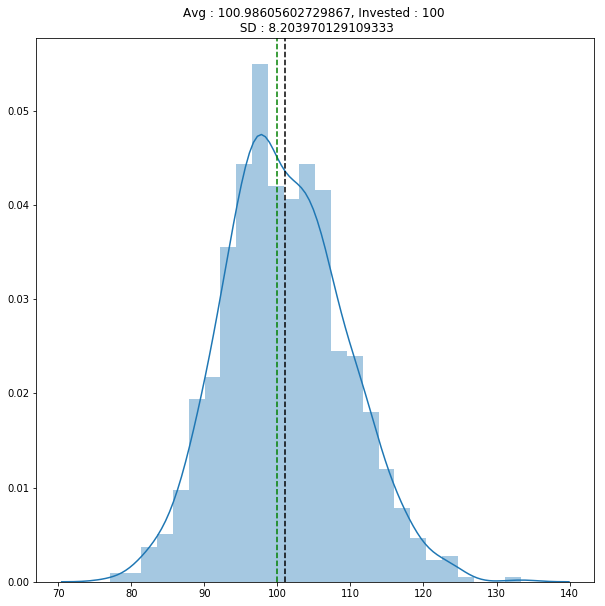

In [279]:
# distribution of results
plt.figure(figsize=(10,10))
sns.distplot(random_sample_result)
plt.axvline(np.mean(random_sample_result), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title(f"Avg : {round(np.mean(random_sample_result), 2)}, Invested : 100 \n SD : {round(np.std(random_sample_result)}")

In [278]:
np.mean(random_sample_result)

100.98605602729867